# SHAP + EXPLAINABILITY 

## imports and data setup

In [1]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json 
from pathlib import Path

In [3]:
warnings.filterwarnings("ignore")

np.random.seed(42)

shap.initjs()

In [8]:

import sys
from pathlib import Path

PROJECT_ROOT = Path(__file__).resolve().parents[2] \
    if "__file__" in globals() \
    else Path.cwd().parents[1]

sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("sys.path[0]:", sys.path[0])


PROJECT_ROOT: C:\great learning self paced\z Final Projects\Fraud-Risk-Intelligence-System
sys.path[0]: C:\great learning self paced\z Final Projects\Fraud-Risk-Intelligence-System


### Load artifacts

In [10]:
EXPERIMENTS_DIR = PROJECT_ROOT / "experiments"
MODELS_DIR = EXPERIMENTS_DIR / "models"
ENSEMBLE_DIR = EXPERIMENTS_DIR / "ensemble" 
METRICS_DIR = EXPERIMENTS_DIR / "metrics"
DATA_DIR = PROJECT_ROOT / "data" / "processed"

print("Project root:", PROJECT_ROOT)
print("Models dir:", MODELS_DIR)
print("Ensemble dir:", ENSEMBLE_DIR)
print("Data dir:", DATA_DIR)

Project root: C:\great learning self paced\z Final Projects\Fraud-Risk-Intelligence-System
Models dir: C:\great learning self paced\z Final Projects\Fraud-Risk-Intelligence-System\experiments\models
Ensemble dir: C:\great learning self paced\z Final Projects\Fraud-Risk-Intelligence-System\experiments\ensemble
Data dir: C:\great learning self paced\z Final Projects\Fraud-Risk-Intelligence-System\data\processed


In [11]:
xgb_model = joblib.load(MODELS_DIR / "xgb.joblib")
stacker_model = joblib.load(MODELS_DIR / "stacker.joblib")

print("Loaded XGB model:", type(xgb_model))
print("Loaded stacker model:", type(stacker_model))

Loaded XGB model: <class 'xgboost.sklearn.XGBClassifier'>
Loaded stacker model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


In [12]:
scaler = joblib.load(MODELS_DIR / "scaler.joblib")
encoders = joblib.load(MODELS_DIR / "encoders.joblib")

print("Scaler loaded:", scaler is not None)
print("Encoders loaded:", encoders is not None)

Scaler loaded: True
Encoders loaded: True


In [13]:
with open(ENSEMBLE_DIR / "metrics.json", "r") as f:
    metrics = json.load(f)

META_FEATURES = metrics["meta_features"]
FINAL_THRESHOLD = metrics["final_threshold"]

print("Meta feature count:", len(META_FEATURES))
print("Meta features:", META_FEATURES)
print("Final threshold:", FINAL_THRESHOLD)


Meta feature count: 8
Meta features: ['xgb_oof_proba', 'anomaly_score', 'ae_recon_error', 'cluster_id', 'amount_log', 'merchant_freq', 'account_txn_count', 'last_5_mean_amount']
Final threshold: 0.98


In [14]:
train_df = pd.read_csv(DATA_DIR / "train.csv")
test_df  = pd.read_csv(DATA_DIR / "test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (227845, 72)
Test shape: (56962, 72)


In [15]:
missing = [f for f in META_FEATURES if f not in train_df.columns]
print("Missing meta features in train:", missing)


Missing meta features in train: ['xgb_oof_proba']


In [16]:
with open(MODELS_DIR / "xgb_features.json", "r") as f:
    xgb_features = json.load(f)["features"]


print("XGB feature count (json):", len(xgb_features))
print("XGB model expects:", xgb_model.n_features_in_)
print("Missing in train:", [f for f in xgb_features if f not in train_df.columns])

XGB feature count (json): 53
XGB model expects: 53
Missing in train: []


## Construct SHAP Explainability Dataset

### Build XGB-ready dataset

In [17]:
with open(MODELS_DIR / "xgb_features.json", "r") as f:
    xgb_features = json.load(f)["features"]

X_train_xgb = train_df[xgb_features]

print("X_train_xgb shape:", X_train_xgb.shape)
print("Expected feature count:", xgb_model.n_features_in_)
print("First 5 columns:", X_train_xgb.columns[:5].tolist())


X_train_xgb shape: (227845, 53)
Expected feature count: 53
First 5 columns: ['Time', 'V1', 'V2', 'V3', 'V4']


###  Fit SHAP TreeExplainer

#### Initialize SHAP TreeExplainer

In [18]:

explainer = shap.TreeExplainer(xgb_model)

print("TreeExplainer initialized.")

TreeExplainer initialized.


#### Sample data for SHAP computation

In [19]:
# Use a representative subset for global explanations
SHAP_SAMPLE_SIZE = 5000

X_shap = X_train_xgb.sample(
    n=SHAP_SAMPLE_SIZE,
    random_state=42
)

print("SHAP sample shape:", X_shap.shape)

SHAP sample shape: (5000, 53)


#### Compute SHAP values

In [20]:
shap_values = explainer.shap_values(X_shap)

print("SHAP values computed.")
print("SHAP values shape:", np.array(shap_values).shape)

SHAP values computed.
SHAP values shape: (5000, 53)


###  Global SHAP summary plot

In [21]:
SHAP_DIR = EXPERIMENTS_DIR / "shap"
SHAP_DIR.mkdir(parents=True, exist_ok=True)

print("SHAP output dir:", SHAP_DIR)

SHAP output dir: C:\great learning self paced\z Final Projects\Fraud-Risk-Intelligence-System\experiments\shap


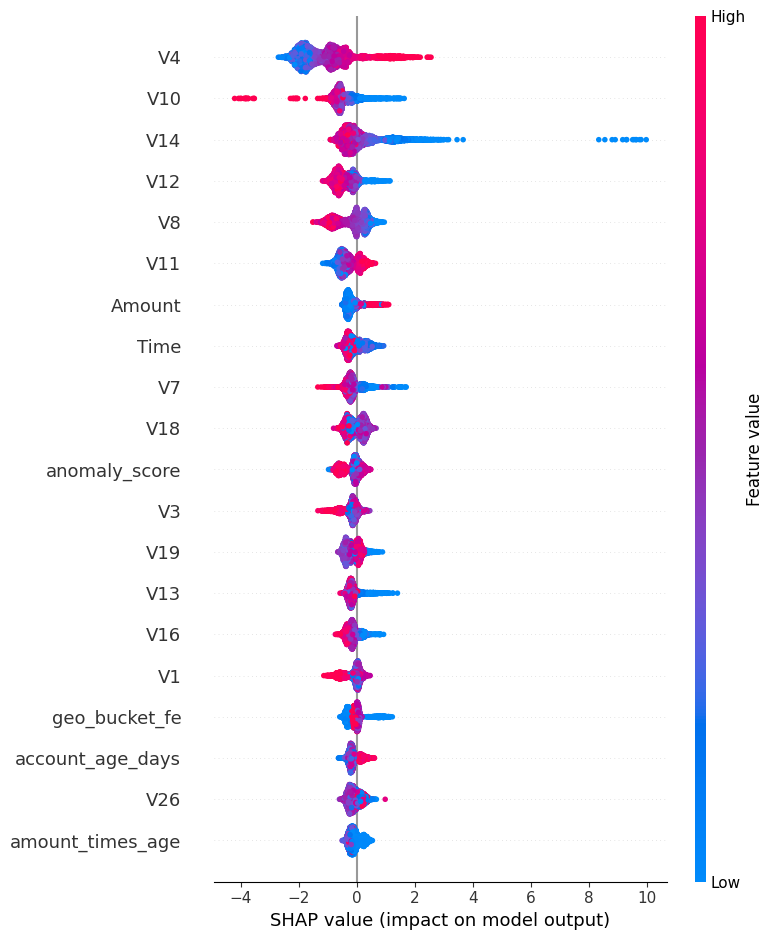

Saved global_summary.png


In [22]:
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_shap,
    show=False
)
plt.tight_layout()
plt.savefig(SHAP_DIR / "global_summary.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved global_summary.png")

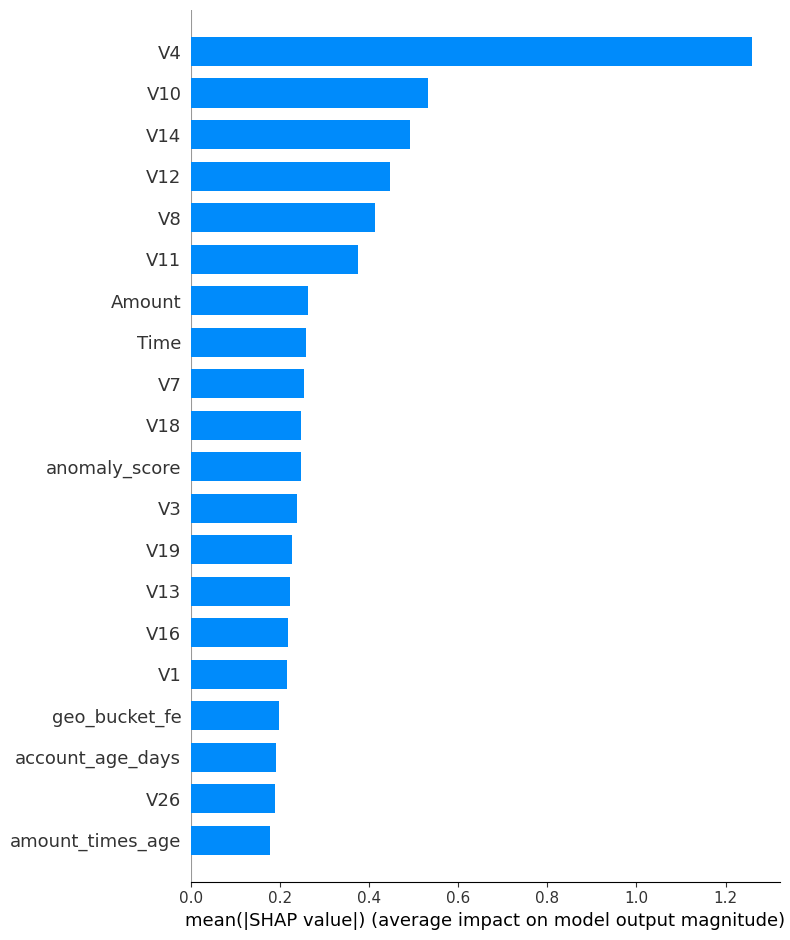

Saved global_bar.png


In [23]:

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    show=False
)
plt.tight_layout()
plt.savefig(SHAP_DIR / "global_bar.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved global_bar.png")

## Local SHAP Analysis



### Select samples


In [38]:
# C0 — Build SMALL analysis dataframe for local SHAP (FAST)

import pandas as pd
from src.models import load_models, predict_proba

models = load_models()

# Load processed test data
test_df = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "test.csv")

# Sample aggressively (this is analysis, not evaluation)
test_df = test_df.sample(n=5000, random_state=42).reset_index(drop=True)

y_true = test_df["Class"].values
X_eval = test_df.drop(columns=["Class"])

probas = []
for _, row in X_eval.iterrows():
    probas.append(predict_proba(row.to_dict()))

analysis_df = X_eval.copy()
analysis_df["y_true"] = y_true
analysis_df["proba"] = probas

print("analysis_df shape:", analysis_df.shape)


analysis_df shape: (5000, 73)


In [39]:
from src.models import load_models
models = load_models()

THRESH = models["threshold"]

analysis_df["y_pred"] = (analysis_df["proba"] >= THRESH).astype(int)

TP = analysis_df[
    (analysis_df["y_true"] == 1) & (analysis_df["y_pred"] == 1)
]

FP = analysis_df[
    (analysis_df["y_true"] == 0) & (analysis_df["y_pred"] == 1)
]

FN = analysis_df[
    (analysis_df["y_true"] == 1) & (analysis_df["y_pred"] == 0)
]

borderline = analysis_df[
    (analysis_df["proba"] >= THRESH - 0.05) &
    (analysis_df["proba"] <= THRESH + 0.05)
]

cases = {}

if len(TP) > 0:
    cases["TP"] = TP.index[0]

if len(FP) > 0:
    cases["FP"] = FP.index[0]

if len(FN) > 0:
    cases["FN"] = FN.index[0]

if len(borderline) > 0:
    cases["borderline"] = borderline.index[0]

cases


{'TP': np.int64(1109), 'FP': np.int64(0), 'borderline': 0}

### SHAP force plots (XGBoost component)

In [41]:
case_name = "TP"  # or "borderline"
i = cases[case_name]

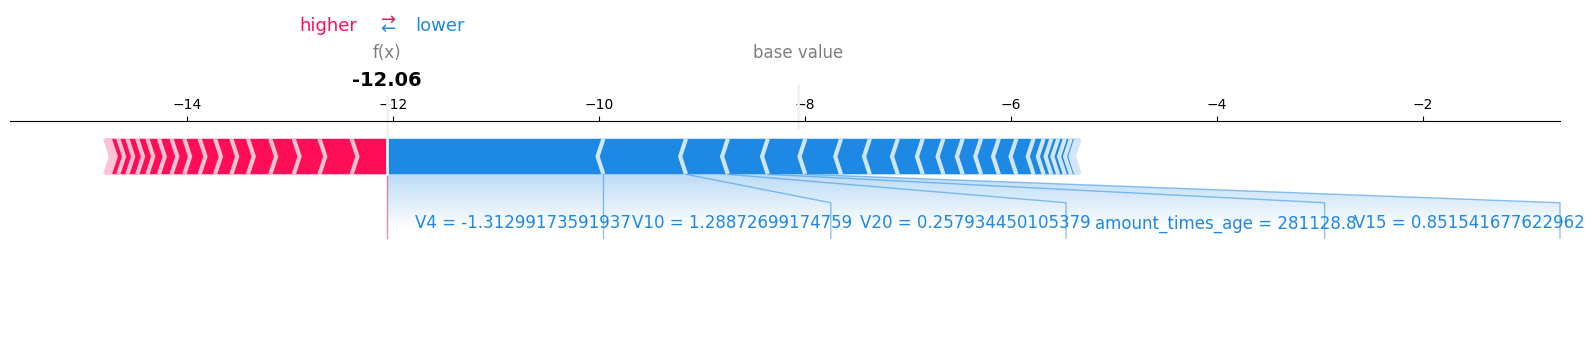

<Figure size 640x480 with 0 Axes>

In [42]:
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_shap.iloc[i],
    matplotlib=True
)

plt.tight_layout()
plt.savefig(SHAP_DIR / "tp_force.png", dpi=300, bbox_inches="tight")

plt.show()


In [43]:
shap.save_html(
    str(SHAP_DIR / f"{case_name.lower()}_force.html"),
    shap.force_plot(
        explainer.expected_value,
        shap_values[i],
        X_shap.iloc[i]
    )
)


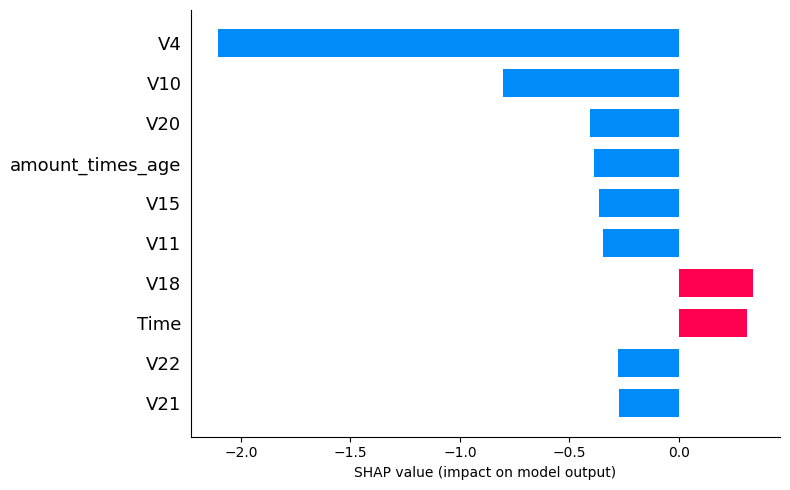

In [44]:
# C3 — SHAP bar plot (array-based, compatible)

plt.figure(figsize=(8, 5))

shap.bar_plot(
    shap_values[i],
    feature_names=X_shap.columns,
    max_display=10,
    show=False
)

plt.tight_layout()
plt.savefig(
    SHAP_DIR / f"{case_name.lower()}_top10.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [45]:
# E1 — Production explainability strategy (no artifact export)

print("Explainability strategy:")
print("- TreeExplainer will be recomputed at API startup")
print("- Using xgb.joblib + xgb_features.json")
print("- No explainer object is serialized")


Explainability strategy:
- TreeExplainer will be recomputed at API startup
- Using xgb.joblib + xgb_features.json
- No explainer object is serialized


In [46]:
# E2 — Top-K SHAP extraction prototype

def get_topk_shap(index, k=5):
    """
    Return top-k SHAP contributors for a single example.
    """
    values = shap_values[index]
    names = X_shap.columns

    sorted_pairs = sorted(
        zip(names, values),
        key=lambda x: abs(x[1]),
        reverse=True
    )

    return sorted_pairs[:k]


In [47]:
get_topk_shap(cases["TP"], k=5)


[('V4', np.float32(-2.1048305)),
 ('V10', np.float32(-0.8017869)),
 ('V20', np.float32(-0.40678677)),
 ('amount_times_age', np.float32(-0.38800484)),
 ('V15', np.float32(-0.36340877))]